In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
class MLPCA:

  def _fit_analytical(self, X):
    """ 解析解を求めて学習を行うメソッド"""
    self.d = len(X[0])
    self.m = 1
    self.mu = np.mean(X, axis=0)
    S = np.cov(X, rowvar=False, ddof=0) #(d, N)
    eigenvals, eigenvec = np.linalg.eig(S)
    ind = np.argsort(eigenvals)[::-1][0:self.m]
    eigenvals_largest = eigenvals[ind]
    eigenvecs_largest = eigenvec[:,ind]
    if self.d != self.m:
      self.variance = 1/(self.d - self.m) * np.sum(np.sort(eigenvals)[::-1][self.m:])
    else:
      self.variance = 0
    self.W = eigenvecs_largest @ np.diag(np.sqrt(eigenvals_largest - self.variance))

  def _init_params(self, X, W=None, variance=None):
    """MアルゴリズムのためにパラメーターW, varianceを初期化するメソッド。初期化の仕方は入力X(観測変数)に依存するとする"""
    self.d = len(X[0])
    self.mu = np.mean(X, axis=0)
    self.W = np.eye(self.d)[:,:self.m] if (W is None) else W
    self.variance = 1.0 if (variance is None) else variance

  def _estep(self, X):
   M_inv = np.linalg.inv( self.W.T @ self.W + self.variance*np.eye(self.m)) #(M, M)
   dx = X - self.mu #(N, d)
   Ez = dx @ self.W @ M_inv #(N, D) @ (D, M) @ (M, M) = (N, M)
   sumEzz = self.variance * M_inv + (Ez.T) @ Ez #(M,M)
   return Ez, sumEzz

  def _mstep(self, X, Ez, sumEzz):
    dx = X - self.mu #(N, D)
    self.W = (dx.T @ Ez) @ np.linalg.inv( sumEzz ) #(D, M)
    self.variance = ( np.linalg.norm(dx)**2 - 2*np.trace(Ez @ (self.W.T) @ (dx.T) ) + np.trace( sumEzz @ self.W.T @ self.W ) )  /(len(X)*self.d)
  
  def _fit_em(self, X, max_iter=100, tol=1e-4, disp_message=False, W0=None, variance0=None):
    self.d = len(X[0])
    self.m = 1
    self._init_params(X, W=W0, variance=variance0)
    
    for i in range(max_iter):
      W_old = self.W
      variance_old = self.variance

      Ez, sumEzz = self._estep(X)
      self._mstep(X, Ez, sumEzz)

      err = np.sqrt(np.linalg.norm(self.W - W_old)**2 + (self.variance - variance_old)**2)
      if err < tol:
        break
      
    if disp_message:
      print(f"n_iter:{i}")
      print(f"converged:{i < max_iter - 1}")

  def fit(self, X, method="analytical", **kwargs):
    if method == "analytical":
      self._fit_analytical(X)
    elif method == "em":
      self._fit_em(X, **kwargs)
    else:
      print("Method should be either 'analytical' or 'em'")
  
  def transform(self, X, return_cov=False):
    """観測変数のデータを入力として受け取り、潜在変数に変換する"""
    M_inv = np.linalg.inv( self.W.T @ self.W + self.variance*np.eye(self.m)) #(M, M)
    dx = (X - self.mu)
    z = dx @ self.W @ M_inv.T
    if return_cov:
      cov = self.variance * M_inv
      return z, cov
    else:
      return z

  def inverse_transform(self, Z, return_cov=False):
    X = Z @ (self.W.T) + self.mu
    if return_cov:
      cov = self.variance * np.eye(self.d)
      return X, cov
    else:
      return X 

In [31]:
class BPCA(MLPCA):
  def _init_params(self, X, W=None, variance=None, alpha=None):
    super()._init_params(X, W, variance)
    self.alpha = np.ones(self.m) if (alpha is None) else alpha
  
  def _mstep(self, X, Ez, sumEzz):
    dx = X - self.mu
    self.W = (dx.T @ Ez) @ np.linalg.inv( sumEzz + self.variance*np.diag(self.alpha))
    self.variance = ( np.linalg.norm(dx)**2 - 2*np.trace(Ez @ (self.W.T) @ (dx.T) ) + np.trace( sumEzz @ self.W.T @ self.W ) )  /(len(X)*self.d)

  def _calc_alpha(self):
    wnorms = np.linalg.norm(self.W, axis=0)**2
    for i in range(self.m):
            self.alpha[i] = self.d/wnorms[i] if (wnorms[i] != 0) else np.inf

  def fit(self, X, max_iter=100, tol=1e-4, disp_message=False, W0=None, variance0=None, alpha0=None):
    self.d = len(X[0])
    self.m = 1
    self._init_params(X, W=W0, variance=variance0, alpha=alpha0)
    
    for i in range(max_iter):
      W_old = self.W
      variance_old = self.variance

      Ez, sumEzz = self._estep(X)
      self._mstep(X, Ez, sumEzz)
      self._calc_alpha()

      err = np.sqrt(np.linalg.norm(self.W - W_old)**2 + (self.variance - variance_old)**2)
      if err < tol:
        break
      
    if disp_message:
      print(f"n_iter:{i}")
      print(f"converged:{i < max_iter - 1}")


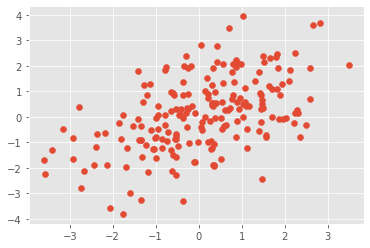

In [32]:
plt.style.use("ggplot")
rnd = np.random.RandomState(0)
X = rnd.multivariate_normal(np.zeros(2), cov=np.array([[2,1],[1,2]]), size=200)
plt.scatter(X[:,0], X[:,1])

### 最尤法
### EM
### Bayse EM



In [33]:
ML = MLPCA()
ML.fit(X, method="analytical")
EM_ML = MLPCA()
EM_ML.fit(X, method="em")
Bayse_EM = BPCA()
Bayse_EM.fit(X)

In [34]:
temp, C_ml = ML.transform(X,return_cov=True)
temp, C_em = EM_ML.transform(X,return_cov=True)
temp, C_bem = Bayse_EM.transform(X, return_cov=True)
error = C_ml - C_em
error2 = C_bem - C_em
print("The difference between C_analytical and C_em :",error)
print("The difference between C_bayse and C_em :",error2)

The difference between C_analytical and C_em : [[0.31557679]]
The difference between C_bayse and C_em : [[0.00090908]]


In [35]:
Bayse_EM.mu

array([0.07765788, 0.09874949])

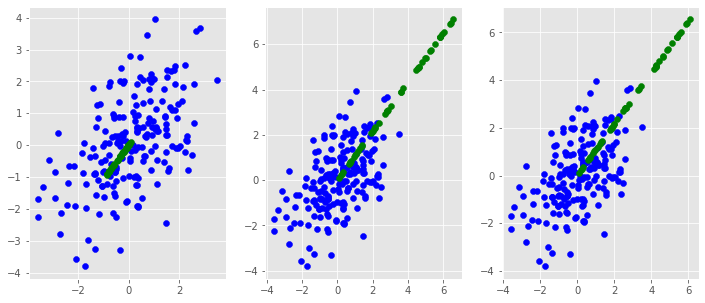

In [37]:
fig, axis = plt.subplots(1,3, figsize=(12,5))
title = ["ML_analytical", "ML_EM", "Baysian"]
for i, name in enumerate(title):
  axis[i].scatter(X[:,0], X[:,1], c="b")

rnd = np.random.RandomState(1)
seed = rnd.rand(50)
seed = np.array([seed]).T
ML_analy = ML.inverse_transform(seed)
ML_EM = EM_ML.inverse_transform(seed)
Bayse = Bayse_EM.inverse_transform(seed)
datas = [ML_analy, ML_EM, Bayse]
for i, data in enumerate(datas):
  axis[i].scatter(data[:,0], data[:,1], c="g", label="generated samples")

plt.show()

In [ ]:
seed.shape